In [1]:
# 加载音频文件
from scipy.io import wavfile

def LoadWav(audio_file):
    sample_rate, signal = wavfile.read(audio_file)
    print('sample_rate:{}, len:{}'.format(sample_rate, len(signal)))
    return sample_rate, signal

In [2]:
import numpy as np

# 获取 MAN 文件
def GenerateManSeq(slotCnt, manFile, FRAME_RATE, BASE_RATE,\
        HIGH_VALUE):
    slotCnt = int(slotCnt)
    manSeq = [0] * slotCnt
    stotal = (FRAME_RATE / BASE_RATE) * slotCnt

    for line in open(manFile):
        sl = line.strip()
        if sl == "" or sl[0] == "#":
            continue
        minute, second = map(int, sl.split(':'))
        stime = minute * 60 + second

        # round to an even number
        pos = round(stime / stotal * slotCnt)

        if 0 <= pos and pos < slotCnt:
            manSeq[pos] = HIGH_VALUE
    return np.array(manSeq)

# 获取 MAN 文件
def GenerateManSeqSec(slotCnt, manFile, FRAME_RATE, BASE_RATE,\
        HIGH_VALUE):
    lis = []

    for line in open(manFile):
        sl = line.strip()
        if sl == "" or sl[0] == "#":
            continue
        minute, second = map(int, sl.split(':'))
        stime = minute * 60 + second
        lis.append(stime)

    return lis

In [3]:
# 生成编号数列

def GetPreSeq(manSeq, length):
    preSeq = manSeq.copy()
    for i in range(1, len(preSeq)):
        preSeq[i] ^= preSeq[i - 1]
        
    assert(abs(len(preSeq) - length) <= 5, "len(preSeq) =%d, length = %d" % (len(preSeq), length))
    return preSeq[:length]

<ipython-input-3-a1912e3b4ef1>:8: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(abs(len(preSeq) - length) <= 5, "len(preSeq) =%d, length = %d" % (len(preSeq), length))


In [4]:
import numpy as np
# np.set_printoptions(threshold=np.inf)

import pylab as pl
import matplotlib.pyplot as plt
from scipy.fftpack import dct
from scipy.io import wavfile
# download opensouce audio in
# http://www.voiptroubleshooter.com/open_speech/american.html
def mfcc(sample_rate, signal):
    # 一、预处理(Preprocess)
    # 加载模型(load audio)
    print('sample_rate:{}, len:{}'.format(sample_rate, len(signal)))

    # signal = signal[: int(3.5 * sample_rate)]  # read first 3.5s data for example.

    # n_frames = len(signal)
    # time = np.arange(0, n_frames) * (1.0 / sample_rate)
    # pl.subplot(1, 1, 1)
    # pl.plot(time, signal)
    # pl.xlabel('time (seconds)')
    # pl.ylabel('amplitude')
    # pl.title('Original audio')
    # pl.show()

    # 预加重(Pre-Emphasis)
    # y(t) = x(t) - a * x(t - 1)
    pre_emphasis = 0.97  # usually 0.95 or 0.97
    emphasized_signal = np.append(
        signal[0],
        signal[1:] - pre_emphasis * signal[: -1]
    )

    # n_frames = len(emphasized_signal)
    # time = np.arange(0, n_frames) * (1.0 / sample_rate)
    # pl.subplot(1, 1, 1)
    # pl.plot(time, emphasized_signal)
    #
    # pl.xlabel('time (seconds)')
    # pl.ylabel('amplitude')
    # pl.title('Pre-Emphasis')
    # pl.show()

    # 分帧(Framing)
    # here, params set as follows:
    # frame_size = 0.025(s), it menas 8kHz signal has 0.025 * 8000 = 200 samples.
    # frame_stride = 0.01(s), 0.01 * 8000 = 80 samples.
    # overlap = 0.015(s), 0.015 * 8000 = 125 samples.
    frame_size, frame_stride, overlap = 0.025, 0.01, 0.015  # Convert from seconds to samples
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate
    singal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(
        float(np.abs(singal_length - frame_length)) / frame_step
    ))  # make sure we have at least 1 frame.

    pad_singal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_singal_length - singal_length))
    # pad singal to make sure that all frames have equal number of
    # samples without truncating any samples from the original signal.
    pad_singal = np.append(emphasized_signal, z)

    indices = np.tile(
        np.arange(0, frame_length), (num_frames, 1)
    ) + np.tile(
        np.arange(0, num_frames * frame_step, frame_step),
        (frame_length, 1)
    ).T
    frames = pad_singal[indices.astype(np.int32, copy=False)]

    # 加窗(Window)
    # W(n, a) = (1 - a) - a * cos(2 * pi * n / (N - 1))
    # 0 <= n <= N, N is Window length, set a = 0.46 here.
    window = np.hamming(frame_length)
    # plt.plot(window)
    # plt.xlabel("Samples")
    # plt.ylabel("Amplitude")
    # plt.title("Hamming window")
    # plt.show()

    # n = np.arange(0, frame_length)
    # window = 0.54 - 0.46 * np.cos(2.0 * np.pi * n) / (frame_length - 1)  # Explicit Implementation
    frames *= window

    # n_frames = len(pad_singal)
    # time = np.arange(0, n_frames) * (1.0 / sample_rate)
    # pl.subplot(1, 1, 1)
    # pl.plot(time, pad_singal)
    #
    # pl.xlabel('time (seconds)')
    # pl.ylabel('amplitude')
    # pl.title('Framing')
    # pl.show()

    # 二、傅里叶变换(FFT)和功率谱(Power Spectrum)
    # do an N-pont FFT on each frame to calculate the frequency spectrum,
    # also called STFT(Short-time FT), where N is typically 256 or 512,
    NFFT = 512
    mag_frames = np.absolute((np.fft.rfft(frames, NFFT)))  # Magnitude of the FFT

    # compute the power spectrum using the following eqution:
    # P = |FFT(Xi)|^2 / N, Xi is ith frame of signal x.
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

    # 三、滤波器组(Filter Banks)
    # The final step to computing filter banks is applying triangular filters,
    # typically 40 filters, nfilt = 40 on a Mel-scale to the power spectrum to extract frequency bands.
    # convert frequency(f) and Mel(m) with equations:
    # m = 2595 * log10(1 + f / 700)
    # f = 700 * (10 ^ (m / 2595) - 1)
    n_filters = 40
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, n_filters + 2)  # need 40 filters banks, so need 42 points
    hz_points = (700 * (10 ** (mel_points / 2595) - 1))  # convert Mel to Hz
    # bin = sample_rate / NFFT  # fequency bin equation
    bins = np.floor((NFFT + 1) * hz_points / sample_rate)  # hz_points / bin

    fbank = np.zeros((n_filters, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, n_filters + 1):
        f_m_minus = int(bins[m - 1])
        f_m = int(bins[m])
        f_m_plus = int(bins[m + 1])

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bins[m - 1]) / (bins[m] - bins[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bins[m + 1] - k) / (bins[m + 1] - bins[m])

    # pl.plot(fbank.T)
    # pl.subplot(1, 1, 1)
    # pl.xlabel("Frequency")
    # pl.ylabel("time()")
    # pl.title("40 Filter Banks")
    # pl.show()

    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
    filter_banks = 20 * np.log10(filter_banks)  # db

    # pl.plot(filter_banks)
    # pl.subplot(1, 1, 1)
    # pl.xlabel("Frequency")
    # pl.ylabel("Time")
    # pl.title("Spectrogram")
    # pl.show()

    # 四、梅尔频率倒谱系数(MFCCs)
    # apply Discrete Cosine Transform (DCT) to decorrelate the filter bank coefficients
    # and yield a compressed representation of the filter banks.
    num_ceps = 12
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 2: (num_ceps + 2)]  # keep 3-14

    # apply sinusoidal liftering to the MFCCs to de-emphasize higher MFCCs
    (n_frames, n_coeff) = mfcc.shape
    n = np.arange(n_coeff)
    cep_lifter = 22
    lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
    mfcc *= lift
    
    mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
    return mfcc

In [5]:
class blank:
    def __init__(self):
        self.id = 0
        self.starttime = 0
        self.endtime = 0
        self.column = 0
        self.cut = 0

    def length(self):
        return self.endtime - self.starttime

    def print(self):
        print("id:%2d stime:%5d etime:%5d column:%d cut:%d" % (self.id, self.starttime, self.endtime, self.column, self.cut))

    def save(self, songid):
        BLANK_DATA_FILE = "./Data/JSON/BlankData.json"

        import json
        with open(BLANK_DATA_FILE) as fp:
            data = json.load(fp)

        data.append({
            'sondid': songid,
            'id': self.id,
            'starttime': self.starttime,
            'endtime': self.endtime,
            'column': self.column,
            'cut': self.cut,
        })
        
        with open(BLANK_DATA_FILE, "w") as fp:
            json.dump(data, fp, indent = 4)


In [6]:
import pandas as pd

def GetMode(segment, K):
    cnt = [0] * K
    for i in range(len(segment)):
       cnt[segment[i]] += 1.0 / len(segment)
    return cnt

In [7]:
def GetKMeans(get_mfcc, K, WINDOW_LEN):
    from sklearn.preprocessing import StandardScaler
    data = get_mfcc.copy()

    scaler = StandardScaler()
    scaler.fit(data)
    data_scaled = scaler.transform(data)

    from sklearn.cluster import KMeans
    kmeans = KMeans(K)
    kmeans.fit(data_scaled)
    mem = kmeans.labels_

    mem_reduce = [0] * len(mem)
    for i in range(len(mem_reduce)):
        mem_reduce[i] = GetMode(mem[max(i-WINDOW_LEN, 0) : min(i + WINDOW_LEN, len(mem_reduce))], K)
    mem_reduce = np.array(mem_reduce)

    return mem_reduce

In [8]:
def countblanks(unknownblank):
    cnt = 0
    blanks = []
    flags = [0, 0, 0, 0, 0, 0, 0, 0]
    isAblank = 0.6
    for i in range(unknownblank.shape[0]):
        for j in range(unknownblank.shape[1]):
            # print(i, j)
            if unknownblank[i][j] > isAblank and flags[j] == 0:
                cnt = cnt + 1
                flags[j] = cnt
                tmp = blank()
                tmp.id = cnt - 1
                tmp.starttime = i
                tmp.column = j
                blanks.append(tmp)
            elif unknownblank[i][j] > isAblank and flags[j] != 0:
                pass
            elif unknownblank[i][j] <= isAblank and flags[j] != 0:
                blanks[flags[j] - 1].endtime = i
                flags[j] = 0
            else: pass
    blanks[-1].endtime = unknownblank.shape[0]
    return blanks

def countpreblanks(preblank):
    cnt = 0
    blanks = []
    flags = 1
    isAblank = 0.6
    for i in range(preblank.shape[0]):
        if preblank[i] > isAblank and flags == 0:
            if cnt > 0:
                blanks[cnt - 1].endtime = i
            flags = 1
            tmp = blank()
            tmp.id = cnt
            tmp.starttime = i
            tmp.column = 8
            blanks.append(tmp)
            cnt = cnt + 1
        elif preblank[i] > isAblank and flags != 0:
            pass
        elif preblank[i] <= isAblank and flags != 0:
            if cnt > 0:
                blanks[cnt - 1].endtime = i
            flags = 0
            tmp = blank()
            tmp.id = cnt
            tmp.starttime = i
            tmp.column = 8
            blanks.append(tmp)
            cnt = cnt + 1
        else: pass
    blanks[-1].endtime = preblank.shape[0]
    return blanks

In [9]:
def judge(blanks, preblanks):
    MAXERROR = 400
    for blank in blanks:
        et = blank.endtime
        for pblank in preblanks:
            pet = pblank.endtime
            if pet >= et - MAXERROR and pet <= et + MAXERROR:
                blank.cut = 1
    return

In [10]:
def ShowMapForWav(wavFileName, manFileName, K = 16, WINDOW_LEN = 500, ALPHA = 0.3):
    music_id = wavFileName.split('/')[-1].split('.')[0]
    print("MUSIC_ID:", music_id)

    sample_rate, signal = LoadWav(wavFileName)
    get_mfcc = mfcc(sample_rate, signal)
    RATE = len(signal) / len(get_mfcc)

    # 总秒数 
    # totalTime = len(signal) // sample_rate

    manSeq = GenerateManSeq(len(signal) // RATE, manFileName, RATE, sample_rate, 1)
    
    get_pre = GetPreSeq(manSeq, len(get_mfcc))
    mem_reduce = GetKMeans(get_mfcc, K, WINDOW_LEN)
    
    ktmp = K // 2
    wtmp = WINDOW_LEN // 2
    while ktmp >= 8:
        mem_reduce = GetKMeans(mem_reduce, ktmp, 3)
        ktmp = ktmp // 2
        wtmp = wtmp // 2
    
    mem_blank = mem_reduce.copy()
    # for i in range(mem_blank.shape[0]):
    #    for j in range(mem_blank.shape[1]):
    #        if mem_blank[i][j] >= ALPHA:
    #            mem_blank[i][j] = 1
    #        elif mem_blank[i][j] >= ALPHA * 0.9:
    #            mem_blank[i][j] = 0.5
    #        else:
    #            mem_blank[i][j] = 0

    # 总帧数
    # totalCnt = len(mem_blank)
    plt.figure(figsize=(19, 5))

    print("SHAPE:", mem_blank.shape, len(get_pre))
    if mem_blank.shape[0] != len(get_pre):
        mem_blank = mem_blank[:len(get_pre),:]
        print("SHAPE:", mem_blank.shape, len(get_pre))
    print(mem_blank)
    # print(pd.Series(np.array(mem_blank).flatten()).value_counts())

    blanks = countblanks(mem_blank)
    preblanks = countpreblanks(get_pre)

    judge(blanks, preblanks)
    for b in blanks:
        b.print()
        b.save(music_id)
    
    import seaborn as sns
    sns.heatmap(np.c_[mem_blank, get_pre].T)

    # 要先保存再显示
    # plt.savefig('./Data/NEWPIC/%s.png' % music_id)
    plt.show()

MUSIC_ID: 0004
sample_rate:44100, len:4896864
sample_rate:44100, len:4896864
SHAPE: (22206, 8) 22206
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
id: 0 stime:    0 etime:  504 column:3 cut:0
id: 1 stime:  505 etime: 3110 column:4 cut:0
id: 2 stime: 3111 etime: 5537 column:7 cut:0
id: 3 stime: 5538 etime: 6659 column:6 cut:0
id: 4 stime: 6660 etime: 8799 column:2 cut:1
id: 5 stime: 8800 etime: 9007 column:6 cut:1
id: 6 stime: 9008 etime:12258 column:4 cut:0
id: 7 stime:12259 etime:15094 column:1 cut:1
id: 8 stime:15095 etime:17678 column:2 cut:1
id: 9 stime:17679 etime:20007 column:0 cut:0
id:10 stime:20008 etime:21493 column:5 cut:0
id:11 stime:21494 etime:22206 column:3 cut:1


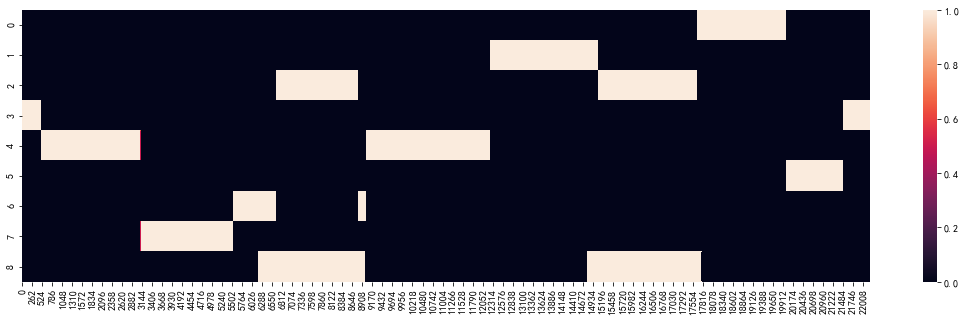

In [11]:
# ShowMapForWav("./Data/WAV/0004.wav", "./Data/MAN/0004.man")

MUSIC_ID: 0003
sample_rate:44100, len:6290188
sample_rate:44100, len:6290188
SHAPE: (28525, 8) 28524
SHAPE: (28524, 8) 28524
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
id: 0 stime:    0 etime: 1319 column:2 cut:0
id: 1 stime: 1320 etime: 2207 column:7 cut:1
id: 2 stime: 2208 etime: 3140 column:1 cut:0
id: 3 stime: 3141 etime: 3334 column:6 cut:0
id: 4 stime: 3335 etime: 5861 column:1 cut:1
id: 5 stime: 5862 etime: 6585 column:3 cut:0
id: 6 stime: 6586 etime: 7298 column:6 cut:0
id: 7 stime: 7299 etime: 8127 column:3 cut:0
id: 8 stime: 8128 etime: 9402 column:6 cut:0
id: 9 stime: 9403 etime: 9871 column:3 cut:1
id:10 stime: 9872 etime: 9994 column:1 cut:1
id:11 stime: 9995 etime:11995 column:4 cut:1
id:12 stime:11996 etime:15694 column:1 cut:1
id:13 stime:15695 etime:15744 column:3 cut:1
id:14 stime:15745 etime:15786 column:1 cut:1
id:15 stime:15787 etime:16608 column:3 cut:0

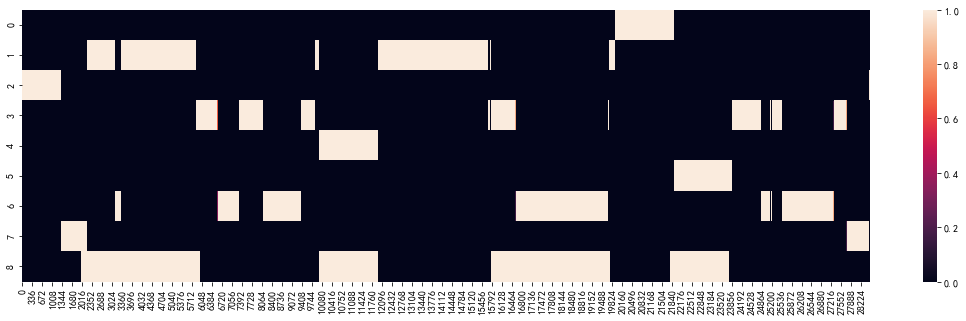

MUSIC_ID: 0004
sample_rate:44100, len:4896864
sample_rate:44100, len:4896864
SHAPE: (22206, 8) 22206
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
id: 0 stime:    0 etime:  507 column:3 cut:0
id: 1 stime:  508 etime: 3066 column:1 cut:0
id: 2 stime: 3067 etime: 5538 column:2 cut:0
id: 3 stime: 5539 etime: 6661 column:5 cut:0
id: 4 stime: 6662 etime: 8793 column:4 cut:1
id: 5 stime: 8794 etime: 9034 column:5 cut:1
id: 6 stime: 9035 etime:12232 column:1 cut:0
id: 7 stime:12233 etime:15082 column:7 cut:1
id: 8 stime:15083 etime:17680 column:4 cut:1
id: 9 stime:17681 etime:20002 column:0 cut:0
id:10 stime:20003 etime:21496 column:6 cut:0
id:11 stime:21497 etime:22206 column:3 cut:1


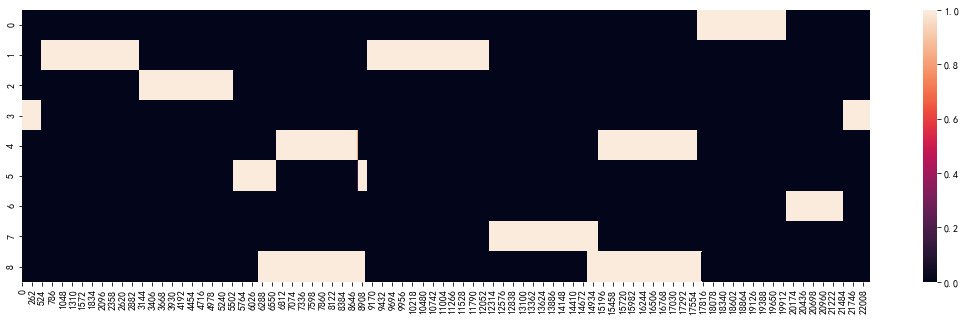

MUSIC_ID: 0005
sample_rate:44100, len:9821184
sample_rate:44100, len:9821184
SHAPE: (44539, 8) 44539
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
id: 0 stime:    0 etime: 2214 column:2 cut:1
id: 1 stime: 2215 etime: 3440 column:7 cut:0
id: 2 stime: 3441 etime: 3664 column:1 cut:0
id: 3 stime: 3665 etime: 7303 column:6 cut:1
id: 4 stime: 7304 etime: 7615 column:1 cut:1
id: 5 stime: 7616 etime: 8688 column:4 cut:0
id: 6 stime: 8689 etime: 9370 column:0 cut:0
id: 7 stime: 9371 etime:10389 column:4 cut:0
id: 8 stime:10390 etime:11032 column:1 cut:0
id: 9 stime:11033 etime:11984 column:5 cut:0
id:10 stime:11985 etime:13911 column:0 cut:0
id:11 stime:13912 etime:17735 column:5 cut:0
id:12 stime:17739 etime:17761 column:5 cut:0
id:13 stime:17762 etime:19090 column:7 cut:0
id:14 stime:19091 etime:19791 column:1 cut:0
id:15 stime:19793 etime:19802 column:4 cut:0
id:16 stime:19803 etime

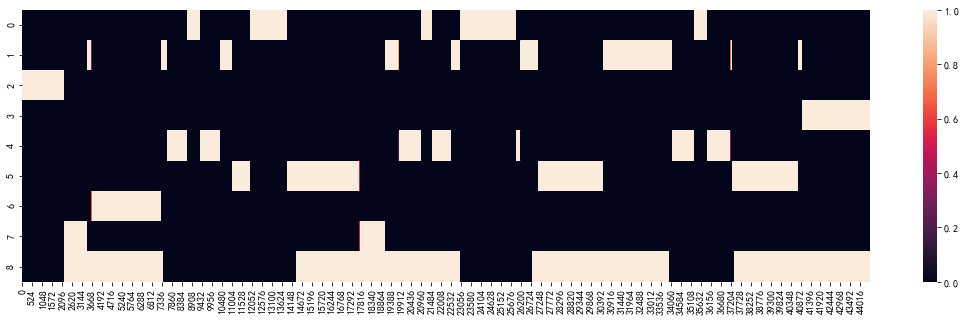

MUSIC_ID: 0006
sample_rate:44100, len:8997888
sample_rate:44100, len:8997888
SHAPE: (40805, 8) 40805
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
id: 0 stime:    0 etime: 1787 column:3 cut:0
id: 1 stime: 1788 etime: 5623 column:1 cut:1
id: 2 stime: 5624 etime: 8974 column:5 cut:0
id: 3 stime: 8975 etime: 9566 column:4 cut:1
id: 4 stime: 9567 etime: 9596 column:2 cut:1
id: 5 stime: 9597 etime:10070 column:4 cut:1
id: 6 stime:10071 etime:10340 column:0 cut:0
id: 7 stime:10341 etime:10670 column:4 cut:0
id: 8 stime:10671 etime:12754 column:0 cut:0
id: 9 stime:12755 etime:14046 column:4 cut:0
id:10 stime:14047 etime:14423 column:0 cut:0
id:11 stime:14424 etime:14490 column:4 cut:0
id:12 stime:14491 etime:15126 column:0 cut:0
id:13 stime:15127 etime:16894 column:4 cut:0
id:14 stime:16895 etime:17329 column:2 cut:0
id:15 stime:17330 etime:20537 column:6 cut:0
id:16 stime:20538 etime

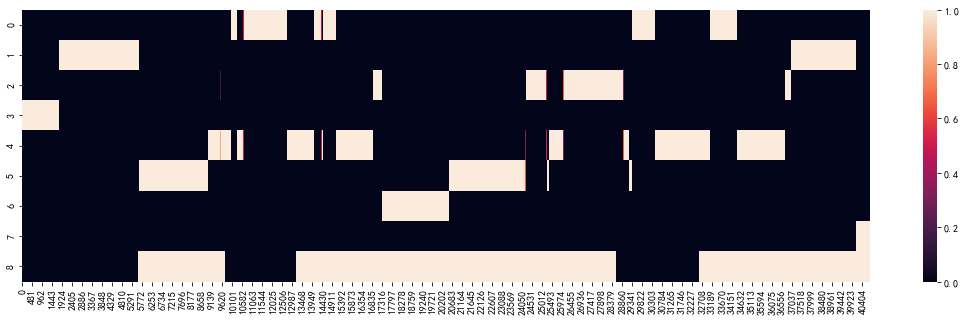

MUSIC_ID: 0007
sample_rate:44100, len:9069568
sample_rate:44100, len:9069568
SHAPE: (41130, 8) 41129
SHAPE: (41129, 8) 41129
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
id: 0 stime:    0 etime: 1535 column:3 cut:1
id: 1 stime: 1536 etime: 1677 column:4 cut:1
id: 2 stime: 1678 etime: 7916 column:0 cut:1
id: 3 stime: 7917 etime: 8496 column:2 cut:1
id: 4 stime: 8497 etime: 8582 column:4 cut:1
id: 5 stime: 8583 etime: 8647 column:2 cut:0
id: 6 stime: 8648 etime:11234 column:1 cut:1
id: 7 stime:11235 etime:14719 column:2 cut:1
id: 8 stime:14720 etime:17939 column:4 cut:1
id: 9 stime:17940 etime:18050 column:2 cut:1
id:10 stime:18051 etime:23510 column:0 cut:0
id:11 stime:23511 etime:25005 column:2 cut:0
id:12 stime:25006 etime:26300 column:1 cut:0
id:13 stime:26301 etime:30979 column:2 cut:0
id:14 stime:30980 etime:34095 column:6 cut:1
id:15 stime:34096 etime:35973 column:7 cut:0

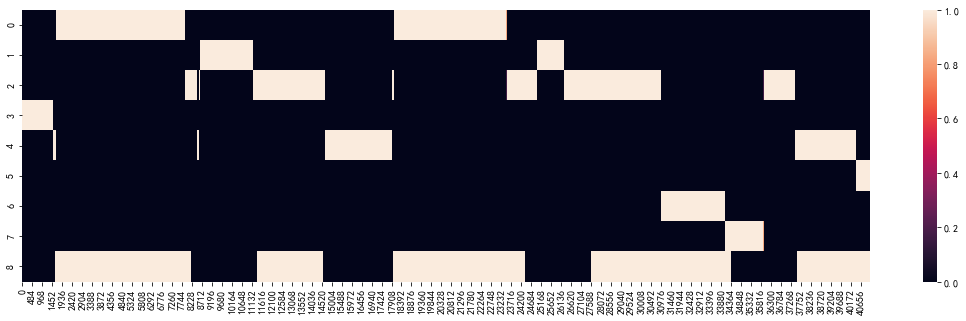

MUSIC_ID: 0008
sample_rate:44100, len:10831872
sample_rate:44100, len:10831872
SHAPE: (49122, 8) 49121
SHAPE: (49121, 8) 49121
[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
id: 0 stime:    0 etime: 1636 column:1 cut:0
id: 1 stime: 1637 etime: 4066 column:2 cut:1
id: 2 stime: 4067 etime: 4529 column:4 cut:1
id: 3 stime: 4530 etime: 4743 column:7 cut:0
id: 4 stime: 4744 etime: 7145 column:3 cut:0
id: 5 stime: 7146 etime: 7658 column:1 cut:0
id: 6 stime: 7659 etime: 9368 column:3 cut:0
id: 7 stime: 9369 etime:11300 column:1 cut:0
id: 8 stime:11301 etime:12310 column:7 cut:1
id: 9 stime:12311 etime:12483 column:6 cut:1
id:10 stime:12484 etime:12522 column:1 cut:1
id:11 stime:12523 etime:12556 column:6 cut:1
id:12 stime:12557 etime:12612 column:1 cut:1
id:13 stime:12613 etime:12918 column:6 cut:1
id:14 stime:12920 etime:17908 column:0 cut:0
id:15 stime:17909 etime:18406 column:6 cut

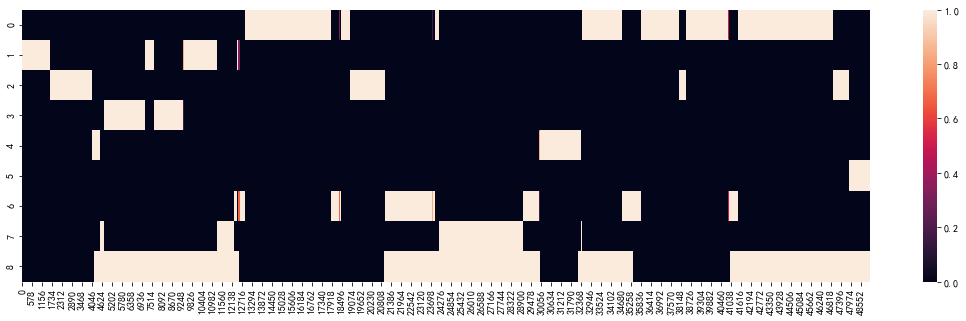

MUSIC_ID: 0009
sample_rate:44100, len:10860544
sample_rate:44100, len:10860544
SHAPE: (49252, 8) 49251
SHAPE: (49251, 8) 49251
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
id: 0 stime:    0 etime:  864 column:5 cut:0
id: 1 stime:  865 etime: 2462 column:1 cut:0
id: 2 stime: 2463 etime: 4018 column:7 cut:0
id: 3 stime: 4019 etime: 4980 column:6 cut:1
id: 4 stime: 4981 etime:11614 column:3 cut:1
id: 5 stime:11615 etime:18180 column:0 cut:1
id: 6 stime:18181 etime:18885 column:7 cut:0
id: 7 stime:18886 etime:21055 column:4 cut:0
id: 8 stime:21056 etime:24577 column:2 cut:1
id: 9 stime:24578 etime:29002 column:3 cut:0
id:10 stime:29003 etime:29711 column:0 cut:0
id:11 stime:29712 etime:31343 column:3 cut:1
id:12 stime:31344 etime:31361 column:0 cut:1
id:13 stime:31362 etime:31368 column:3 cut:1
id:14 stime:31369 etime:44185 column:0 cut:0
id:15 stime:44186 etime:44397 column:3 cut

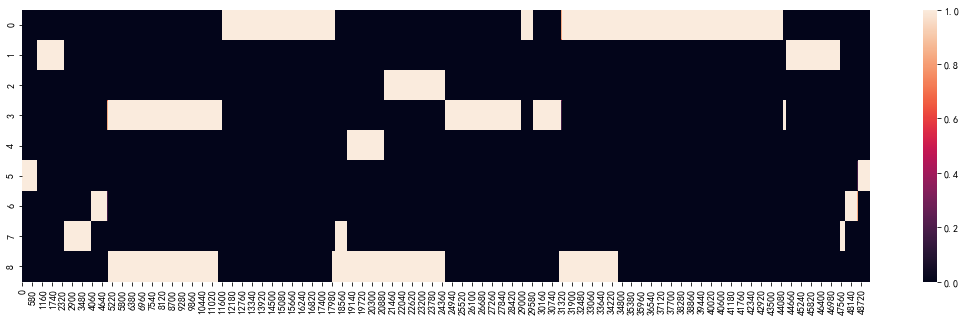

MUSIC_ID: 0010
sample_rate:48000, len:10515456
sample_rate:48000, len:10515456
SHAPE: (43812, 8) 43811
SHAPE: (43811, 8) 43811
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
id: 0 stime:    0 etime: 1470 column:7 cut:0
id: 1 stime: 1471 etime: 4265 column:2 cut:1
id: 2 stime: 4266 etime: 4467 column:1 cut:0
id: 3 stime: 4468 etime: 6762 column:6 cut:0
id: 4 stime: 6763 etime: 9585 column:1 cut:0
id: 5 stime: 9586 etime:11464 column:4 cut:0
id: 6 stime:11465 etime:11468 column:1 cut:0
id: 7 stime:11469 etime:11509 column:4 cut:0
id: 8 stime:11510 etime:12387 column:1 cut:1
id: 9 stime:12388 etime:13840 column:0 cut:0
id:10 stime:13841 etime:13933 column:3 cut:0
id:11 stime:13937 etime:15510 column:3 cut:0
id:12 stime:15511 etime:16721 column:0 cut:0
id:13 stime:16722 etime:18767 column:3 cut:1
id:14 stime:18768 etime:19122 column:1 cut:0
id:15 stime:19123 etime:21862 column:4 cut

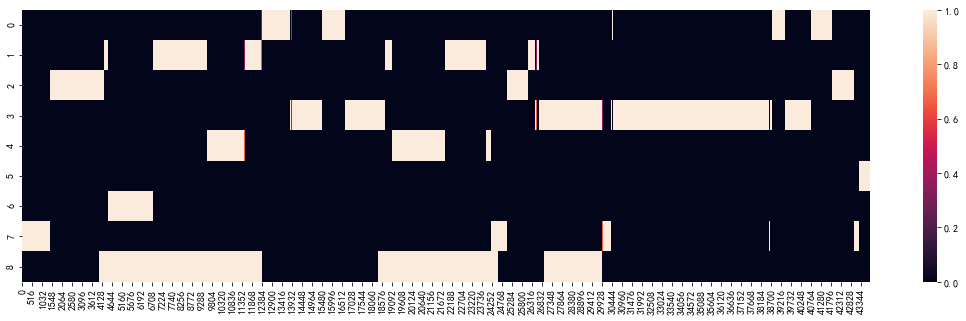

MUSIC_ID: 0011
sample_rate:44100, len:12812288
sample_rate:44100, len:12812288
SHAPE: (58104, 8) 58103
SHAPE: (58103, 8) 58103
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
id: 0 stime:    0 etime: 2504 column:4 cut:0
id: 1 stime: 2505 etime: 5299 column:2 cut:1
id: 2 stime: 5300 etime: 5743 column:0 cut:0
id: 3 stime: 5744 etime: 9792 column:6 cut:0
id: 4 stime: 9793 etime: 9804 column:0 cut:0
id: 5 stime: 9805 etime:10625 column:5 cut:0
id: 6 stime:10626 etime:10827 column:0 cut:0
id: 7 stime:10828 etime:10872 column:1 cut:0
id: 8 stime:10873 etime:13377 column:0 cut:1
id: 9 stime:13378 etime:18710 column:1 cut:1
id:10 stime:18711 etime:21366 column:3 cut:1
id:11 stime:21367 etime:23063 column:0 cut:0
id:12 stime:23064 etime:23338 column:5 cut:0
id:13 stime:23339 etime:26152 column:0 cut:0
id:14 stime:26153 etime:26944 column:1 cut:0
id:15 stime:26945 etime:28755 column:0 cut

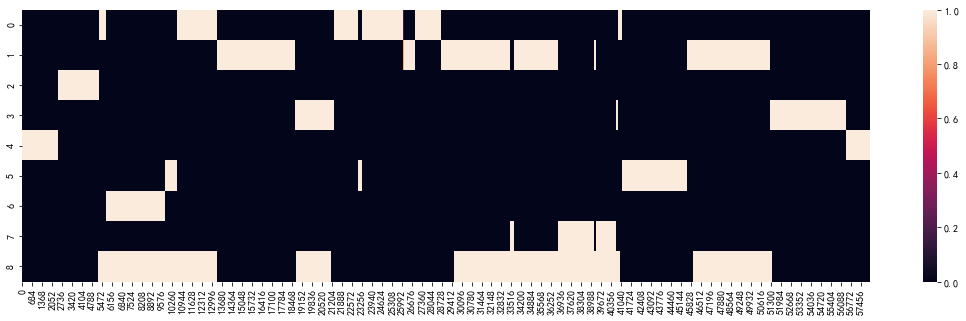

MUSIC_ID: 0012
sample_rate:48000, len:8999936
sample_rate:48000, len:8999936
SHAPE: (37498, 8) 37498
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
id: 0 stime:    0 etime: 3005 column:4 cut:1
id: 1 stime: 3006 etime: 3696 column:1 cut:0
id: 2 stime: 3697 etime: 8218 column:2 cut:0
id: 3 stime: 8219 etime: 8226 column:7 cut:0
id: 4 stime: 8227 etime:11964 column:2 cut:1
id: 5 stime:11965 etime:15178 column:7 cut:1
id: 6 stime:15179 etime:18158 column:6 cut:1
id: 7 stime:18159 etime:18413 column:2 cut:0
id: 8 stime:18414 etime:20115 column:1 cut:0
id: 9 stime:20116 etime:22752 column:2 cut:0
id:10 stime:22753 etime:22854 column:7 cut:0
id:11 stime:22855 etime:22871 column:2 cut:0
id:12 stime:22872 etime:22928 column:7 cut:0
id:13 stime:22929 etime:24578 column:2 cut:1
id:14 stime:24579 etime:25649 column:1 cut:1
id:15 stime:25650 etime:25664 column:2 cut:1
id:16 stime:25668 etime

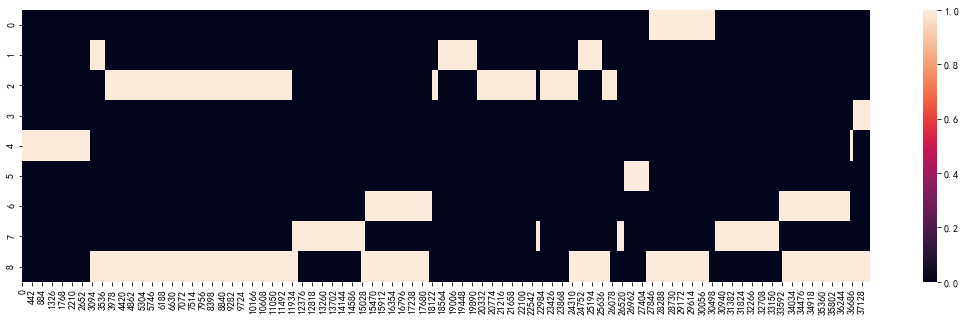

MUSIC_ID: 0013
sample_rate:44100, len:9261056
sample_rate:44100, len:9261056
SHAPE: (41998, 8) 41997
SHAPE: (41997, 8) 41997
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
id: 0 stime:    0 etime: 1647 column:6 cut:0
id: 1 stime: 1648 etime: 3117 column:3 cut:1
id: 2 stime: 3118 etime: 6274 column:1 cut:1
id: 3 stime: 6275 etime: 9527 column:5 cut:1
id: 4 stime: 9528 etime:10174 column:1 cut:0
id: 5 stime:10175 etime:11251 column:2 cut:0
id: 6 stime:11252 etime:11474 column:1 cut:0
id: 7 stime:11475 etime:11480 column:2 cut:0
id: 8 stime:11481 etime:11676 column:1 cut:0
id: 9 stime:11677 etime:11770 column:2 cut:0
id:10 stime:11771 etime:12250 column:1 cut:0
id:11 stime:12251 etime:17153 column:2 cut:0
id:12 stime:17154 etime:18963 column:1 cut:0
id:13 stime:18964 etime:20256 column:2 cut:0
id:14 stime:20257 etime:21470 column:1 cut:1
id:15 stime:21471 etime:22966 column:4 cut:1

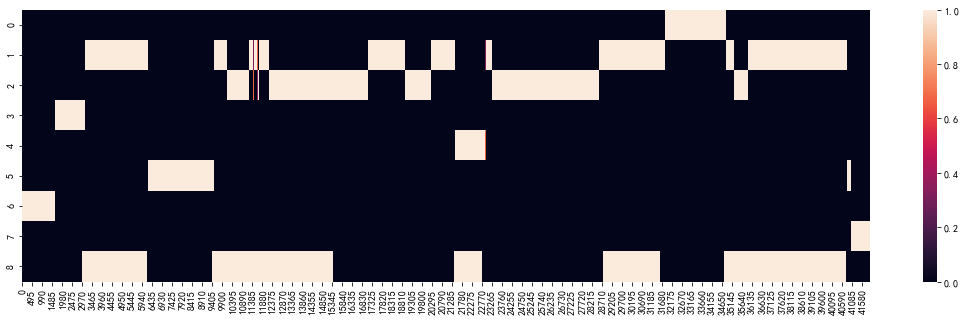

MUSIC_ID: 0014
sample_rate:44100, len:9679872
sample_rate:44100, len:9679872
SHAPE: (43898, 8) 43897
SHAPE: (43897, 8) 43897
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
id: 0 stime:    0 etime:  693 column:4 cut:0
id: 1 stime:  694 etime: 2180 column:6 cut:0
id: 2 stime: 2181 etime: 4031 column:1 cut:1
id: 3 stime: 4032 etime: 5686 column:3 cut:0
id: 4 stime: 5687 etime: 6823 column:5 cut:0
id: 5 stime: 6824 etime: 7792 column:3 cut:1
id: 6 stime: 7793 etime: 7950 column:5 cut:0
id: 7 stime: 7951 etime: 8055 column:3 cut:0
id: 8 stime: 8056 etime: 8064 column:5 cut:0
id: 9 stime: 8065 etime: 8079 column:3 cut:0
id:10 stime: 8080 etime: 8477 column:5 cut:0
id:11 stime: 8478 etime: 9459 column:3 cut:0
id:12 stime: 9460 etime:10367 column:5 cut:0
id:13 stime:10368 etime:11159 column:0 cut:1
id:14 stime:11160 etime:12083 column:5 cut:0
id:15 stime:12084 etime:12426 column:7 cut:0

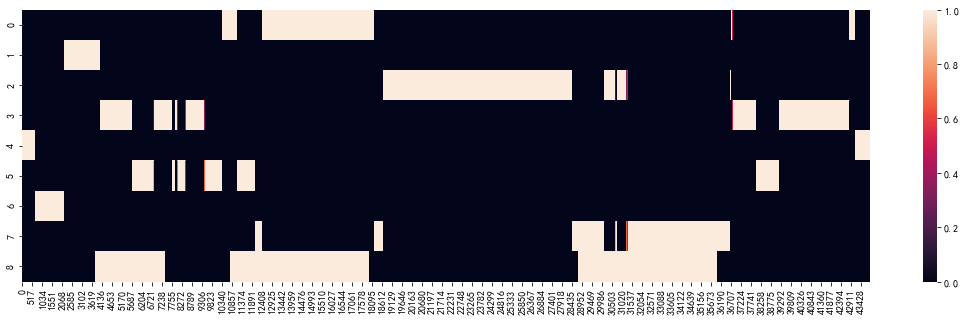

MUSIC_ID: 0015
sample_rate:48000, len:12466176
sample_rate:48000, len:12466176
SHAPE: (51940, 8) 51940
[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
id: 0 stime:    0 etime:  600 column:1 cut:0
id: 1 stime:  601 etime: 1612 column:5 cut:1
id: 2 stime: 1613 etime: 1643 column:3 cut:1
id: 3 stime: 1644 etime: 3925 column:4 cut:0
id: 4 stime: 3926 etime: 4720 column:5 cut:0
id: 5 stime: 4721 etime: 7208 column:7 cut:0
id: 6 stime: 7209 etime:11097 column:2 cut:0
id: 7 stime:11098 etime:11516 column:3 cut:0
id: 8 stime:11517 etime:11528 column:7 cut:0
id: 9 stime:11529 etime:11539 column:3 cut:0
id:10 stime:11540 etime:11544 column:7 cut:0
id:11 stime:11545 etime:11560 column:3 cut:0
id:12 stime:11561 etime:12784 column:7 cut:0
id:13 stime:12785 etime:17559 column:3 cut:0
id:14 stime:17560 etime:18897 column:0 cut:0
id:15 stime:18898 etime:20859 column:6 cut:0
id:16 stime:20860 eti

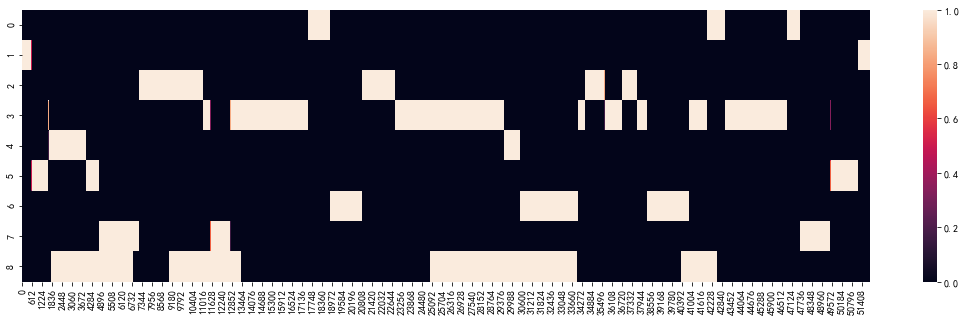

MUSIC_ID: 0016
sample_rate:48000, len:12241920
sample_rate:48000, len:12241920
SHAPE: (51006, 8) 51005
SHAPE: (51005, 8) 51005
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
id: 0 stime:    0 etime: 2181 column:5 cut:0
id: 1 stime: 2182 etime: 3478 column:2 cut:0
id: 2 stime: 3479 etime: 3715 column:4 cut:0
id: 3 stime: 3716 etime: 3847 column:2 cut:1
id: 4 stime: 3848 etime: 4379 column:4 cut:1
id: 5 stime: 4380 etime: 4710 column:1 cut:0
id: 6 stime: 4711 etime: 5018 column:7 cut:0
id: 7 stime: 5019 etime: 8470 column:1 cut:0
id: 8 stime: 8471 etime:11352 column:7 cut:0
id: 9 stime:11353 etime:15895 column:4 cut:0
id:10 stime:15899 etime:15905 column:4 cut:0
id:11 stime:15906 etime:20556 column:0 cut:1
id:12 stime:20557 etime:20800 column:7 cut:1
id:13 stime:20801 etime:22833 column:5 cut:0
id:14 stime:22834 etime:24960 column:2 cut:1
id:15 stime:24961 etime:32168 column:7 cut

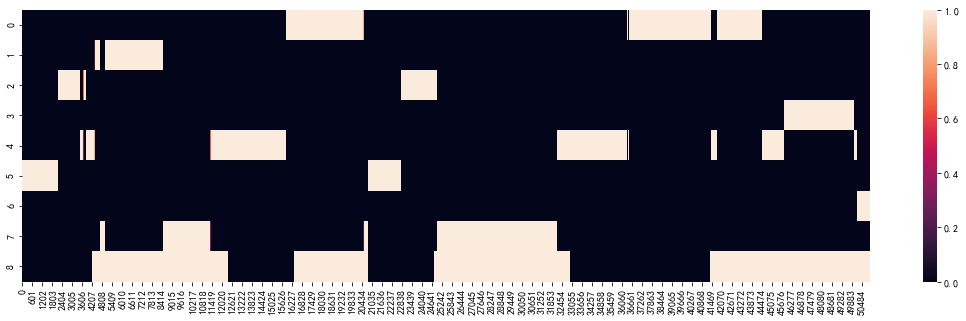

MUSIC_ID: 0017
sample_rate:48000, len:9960448
sample_rate:48000, len:9960448
SHAPE: (41500, 8) 41500
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
id: 0 stime:    0 etime:   50 column:7 cut:0
id: 1 stime:   51 etime: 3239 column:3 cut:1
id: 2 stime: 3240 etime: 6445 column:5 cut:0
id: 3 stime: 6446 etime: 6499 column:4 cut:0
id: 4 stime: 6500 etime: 6511 column:1 cut:0
id: 5 stime: 6512 etime: 9039 column:4 cut:0
id: 6 stime: 9040 etime:14750 column:1 cut:1
id: 7 stime:14751 etime:17304 column:0 cut:1
id: 8 stime:17305 etime:17628 column:4 cut:1
id: 9 stime:17629 etime:20653 column:5 cut:1
id:10 stime:20654 etime:21514 column:4 cut:0
id:11 stime:21515 etime:21520 column:5 cut:0
id:12 stime:21521 etime:21823 column:4 cut:0
id:13 stime:21824 etime:21905 column:5 cut:0
id:14 stime:21906 etime:23268 column:4 cut:0
id:15 stime:23269 etime:29086 column:1 cut:1
id:16 stime:29087 etime

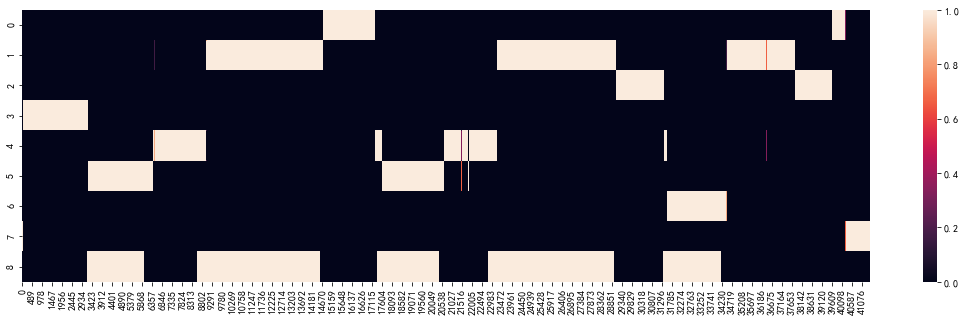

MUSIC_ID: 0018
sample_rate:48000, len:13970432
sample_rate:48000, len:13970432
SHAPE: (58208, 8) 58207
SHAPE: (58207, 8) 58207
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
id: 0 stime:    0 etime:  532 column:7 cut:0
id: 1 stime:  533 etime:  549 column:2 cut:0
id: 2 stime:  550 etime: 2606 column:6 cut:1
id: 3 stime: 2607 etime: 6256 column:1 cut:1
id: 4 stime: 6257 etime: 6837 column:2 cut:0
id: 5 stime: 6838 etime: 8594 column:0 cut:0
id: 6 stime: 8595 etime:12590 column:2 cut:1
id: 7 stime:12591 etime:17781 column:0 cut:0
id: 8 stime:17782 etime:18721 column:2 cut:1
id: 9 stime:18722 etime:21379 column:1 cut:1
id:10 stime:21380 etime:21721 column:2 cut:1
id:11 stime:21722 etime:23084 column:0 cut:0
id:12 stime:23085 etime:23206 column:2 cut:0
id:13 stime:23207 etime:23464 column:0 cut:0
id:14 stime:23465 etime:27803 column:2 cut:0
id:15 stime:27804 etime:33037 column:0 cut

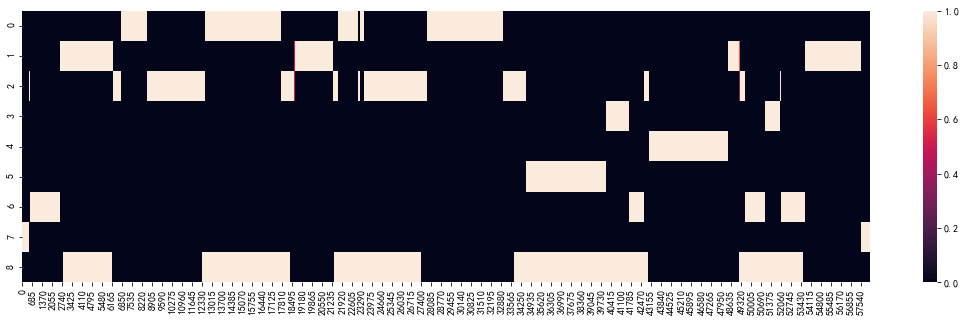

MUSIC_ID: 0019
sample_rate:44100, len:8112128
sample_rate:44100, len:8112128
SHAPE: (36788, 8) 36787
SHAPE: (36787, 8) 36787
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
id: 0 stime:    0 etime:  619 column:3 cut:0
id: 1 stime:  620 etime: 3021 column:6 cut:1
id: 2 stime: 3022 etime: 5415 column:5 cut:0
id: 3 stime: 5416 etime: 7181 column:2 cut:1
id: 4 stime: 7182 etime: 7510 column:5 cut:1
id: 5 stime: 7511 etime:10924 column:0 cut:1
id: 6 stime:10925 etime:12738 column:6 cut:1
id: 7 stime:12739 etime:13173 column:0 cut:1
id: 8 stime:13174 etime:14131 column:2 cut:0
id: 9 stime:14132 etime:15384 column:5 cut:0
id:10 stime:15385 etime:17165 column:2 cut:1
id:11 stime:17166 etime:17287 column:5 cut:1
id:12 stime:17288 etime:20182 column:0 cut:1
id:13 stime:20183 etime:20630 column:5 cut:1
id:14 stime:20631 etime:20904 column:2 cut:0
id:15 stime:20905 etime:25819 column:1 cut:1

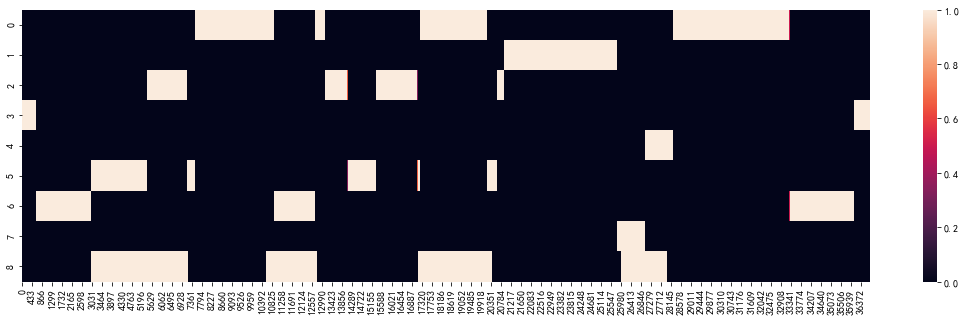

MUSIC_ID: 0020
sample_rate:44100, len:14675968
sample_rate:44100, len:14675968
SHAPE: (66556, 8) 66555
SHAPE: (66555, 8) 66555
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
id: 0 stime:    0 etime:  647 column:6 cut:0
id: 1 stime:  648 etime: 4781 column:2 cut:0
id: 2 stime: 4782 etime: 9556 column:4 cut:1
id: 3 stime: 9557 etime:13718 column:1 cut:1
id: 4 stime:13719 etime:18470 column:3 cut:1
id: 5 stime:18471 etime:27948 column:7 cut:1
id: 6 stime:27949 etime:28465 column:4 cut:0
id: 7 stime:28466 etime:32388 column:2 cut:1
id: 8 stime:32389 etime:36763 column:1 cut:1
id: 9 stime:36764 etime:41391 column:3 cut:1
id:10 stime:41392 etime:42102 column:7 cut:0
id:11 stime:42103 etime:43813 column:5 cut:0
id:12 stime:43814 etime:44429 column:1 cut:0
id:13 stime:44430 etime:50516 column:5 cut:1
id:14 stime:50517 etime:59619 column:7 cut:0
id:15 stime:59620 etime:64922 column:4 cut

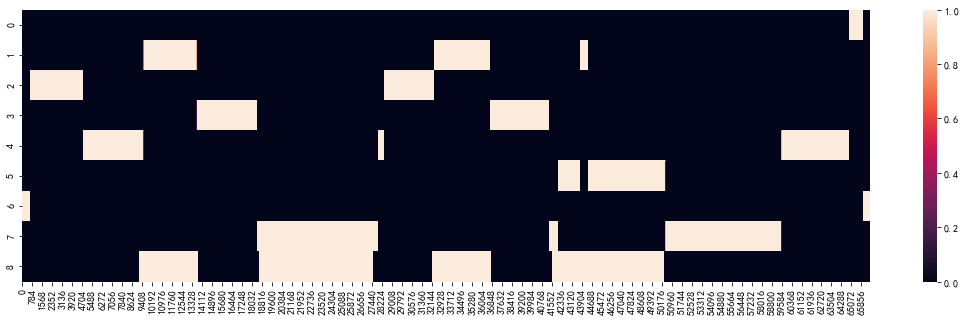

MUSIC_ID: 0021
sample_rate:48000, len:10848256
sample_rate:48000, len:10848256
SHAPE: (45199, 8) 45198
SHAPE: (45198, 8) 45198
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
id: 0 stime:    0 etime:  715 column:4 cut:0
id: 1 stime:  716 etime: 2570 column:6 cut:0
id: 2 stime: 2571 etime: 4928 column:3 cut:1
id: 3 stime: 4929 etime: 5221 column:1 cut:1
id: 4 stime: 5222 etime: 9402 column:5 cut:0
id: 5 stime: 9403 etime:11633 column:2 cut:1
id: 6 stime:11635 etime:11912 column:5 cut:1
id: 7 stime:11913 etime:16694 column:1 cut:1
id: 8 stime:16695 etime:18819 column:7 cut:1
id: 9 stime:18820 etime:18871 column:0 cut:1
id:10 stime:18872 etime:21891 column:5 cut:0
id:11 stime:21892 etime:22186 column:0 cut:0
id:12 stime:22187 etime:23115 column:5 cut:0
id:13 stime:23116 etime:25274 column:2 cut:1
id:14 stime:25275 etime:30059 column:1 cut:1
id:15 stime:30060 etime:30496 column:3 cut

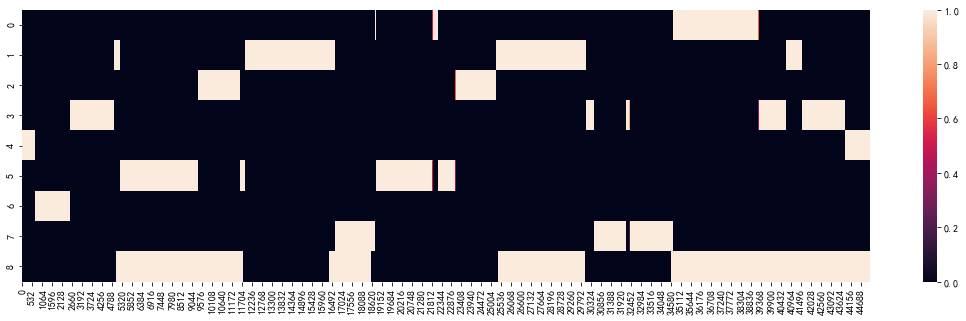

MUSIC_ID: 0022
sample_rate:48000, len:10139648
sample_rate:48000, len:10139648
SHAPE: (42247, 8) 42247
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
id: 0 stime:    0 etime:  446 column:5 cut:0
id: 1 stime:  447 etime: 1389 column:1 cut:0
id: 2 stime: 1390 etime: 4209 column:5 cut:0
id: 3 stime: 4210 etime: 4256 column:0 cut:0
id: 4 stime: 4257 etime: 4811 column:5 cut:0
id: 5 stime: 4812 etime: 6771 column:2 cut:1
id: 6 stime: 6772 etime: 7099 column:3 cut:0
id: 7 stime: 7100 etime: 8255 column:4 cut:0
id: 8 stime: 8256 etime: 8986 column:0 cut:0
id: 9 stime: 8987 etime:10220 column:3 cut:0
id:10 stime:10221 etime:10358 column:5 cut:0
id:11 stime:10359 etime:11769 column:7 cut:0
id:12 stime:11770 etime:12688 column:0 cut:1
id:13 stime:12689 etime:16492 column:2 cut:1
id:14 stime:16493 etime:16680 column:4 cut:1
id:15 stime:16681 etime:16699 column:2 cut:1
id:16 stime:16700 eti

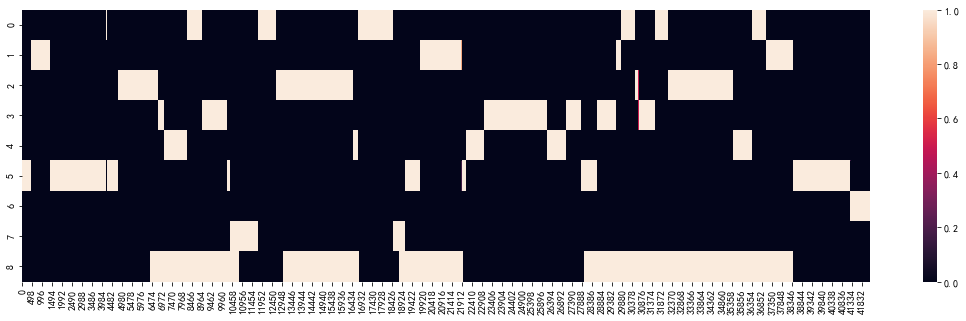

MUSIC_ID: 0023
sample_rate:48000, len:11297792
sample_rate:48000, len:11297792
SHAPE: (47072, 8) 47071
SHAPE: (47071, 8) 47071
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
id: 0 stime:    0 etime:  771 column:3 cut:0
id: 1 stime:  772 etime: 2980 column:7 cut:0
id: 2 stime: 2981 etime: 6595 column:3 cut:1
id: 3 stime: 6596 etime: 7789 column:4 cut:0
id: 4 stime: 7790 etime: 9318 column:2 cut:1
id: 5 stime: 9319 etime: 9838 column:4 cut:0
id: 6 stime: 9839 etime:12261 column:6 cut:1
id: 7 stime:12262 etime:12764 column:4 cut:1
id: 8 stime:12765 etime:17691 column:1 cut:0
id: 9 stime:17692 etime:18789 column:0 cut:1
id:10 stime:18790 etime:21659 column:4 cut:1
id:11 stime:21660 etime:21731 column:1 cut:1
id:12 stime:21732 etime:23309 column:5 cut:0
id:13 stime:23310 etime:23698 column:1 cut:0
id:14 stime:23699 etime:24297 column:5 cut:1
id:15 stime:24298 etime:24443 column:1 cut

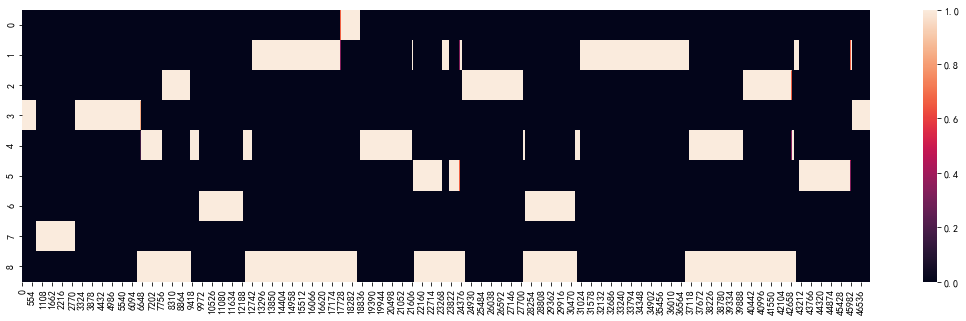

MUSIC_ID: 0024
sample_rate:48000, len:13300736
sample_rate:48000, len:13300736
SHAPE: (55418, 8) 55417
SHAPE: (55417, 8) 55417
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
id: 0 stime:    0 etime:  235 column:5 cut:0
id: 1 stime:  236 etime: 2640 column:4 cut:0
id: 2 stime: 2641 etime: 4842 column:3 cut:1
id: 3 stime: 4843 etime: 5208 column:0 cut:0
id: 4 stime: 5209 etime: 6286 column:6 cut:0
id: 5 stime: 6287 etime:12989 column:0 cut:0
id: 6 stime:12990 etime:13015 column:1 cut:0
id: 7 stime:13016 etime:13035 column:0 cut:0
id: 8 stime:13036 etime:18462 column:1 cut:1
id: 9 stime:18463 etime:21104 column:3 cut:1
id:10 stime:21105 etime:21444 column:0 cut:0
id:11 stime:21445 etime:22497 column:6 cut:0
id:12 stime:22498 etime:29273 column:0 cut:0
id:13 stime:29274 etime:34748 column:1 cut:1
id:14 stime:34749 etime:35241 column:3 cut:1
id:15 stime:35242 etime:35955 column:4 cut

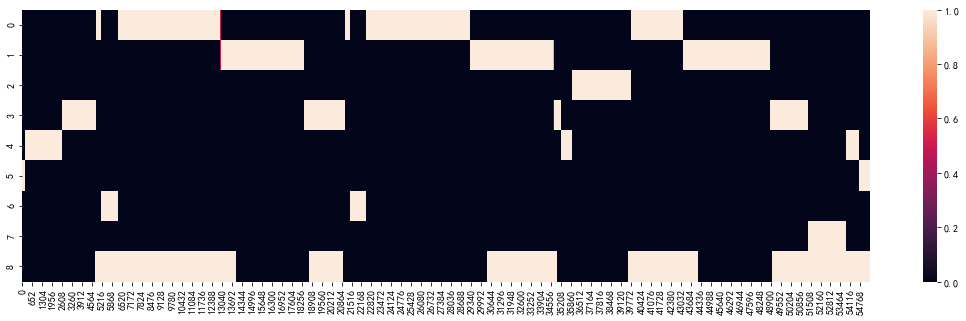

MUSIC_ID: 0025
sample_rate:48000, len:11916288
sample_rate:48000, len:11916288
SHAPE: (49649, 8) 49649
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
id: 0 stime:    0 etime:  571 column:2 cut:0
id: 1 stime:  572 etime: 4947 column:4 cut:1
id: 2 stime: 4948 etime: 5252 column:1 cut:1
id: 3 stime: 5253 etime: 9487 column:5 cut:1
id: 4 stime: 9488 etime:13491 column:1 cut:1
id: 5 stime:13492 etime:17950 column:0 cut:1
id: 6 stime:17951 etime:22103 column:4 cut:1
id: 7 stime:22104 etime:24060 column:1 cut:0
id: 8 stime:24061 etime:24103 column:0 cut:0
id: 9 stime:24104 etime:24142 column:1 cut:0
id:10 stime:24143 etime:24552 column:0 cut:0
id:11 stime:24553 etime:25865 column:4 cut:1
id:12 stime:25866 etime:32592 column:0 cut:0
id:13 stime:32593 etime:33481 column:4 cut:0
id:14 stime:33483 etime:35660 column:0 cut:1
id:15 stime:35661 etime:40353 column:7 cut:1
id:16 stime:40354 eti

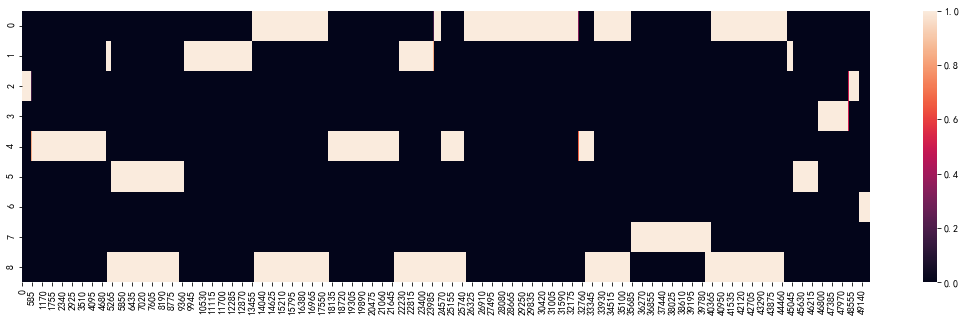

MUSIC_ID: 0026
sample_rate:48000, len:11528192
sample_rate:48000, len:11528192
SHAPE: (48032, 8) 48032
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
id: 0 stime:    0 etime:  556 column:2 cut:0
id: 1 stime:  557 etime: 4726 column:7 cut:1
id: 2 stime: 4727 etime: 8973 column:0 cut:0
id: 3 stime: 8974 etime: 8979 column:3 cut:0
id: 4 stime: 8980 etime: 8998 column:0 cut:0
id: 5 stime: 8999 etime:12176 column:3 cut:0
id: 6 stime:12177 etime:12268 column:4 cut:0
id: 7 stime:12269 etime:13585 column:3 cut:1
id: 8 stime:13586 etime:17780 column:4 cut:1
id: 9 stime:17781 etime:22741 column:5 cut:1
id:10 stime:22742 etime:26415 column:1 cut:0
id:11 stime:26416 etime:27369 column:6 cut:1
id:12 stime:27370 etime:29243 column:3 cut:0
id:13 stime:29244 etime:29333 column:4 cut:0
id:14 stime:29334 etime:29382 column:3 cut:0
id:15 stime:29383 etime:29399 column:4 cut:0
id:16 stime:29400 eti

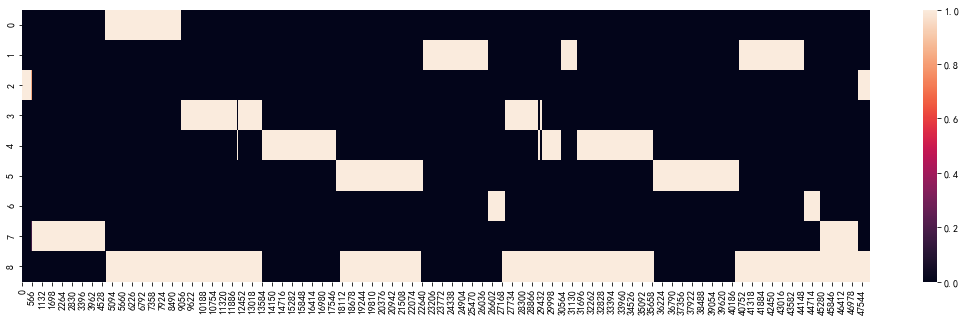

In [13]:
N = 26
for i in range(3, N + 1):
    name = "%04d" % i
    ShowMapForWav("./Data/WAV/%s.wav" % name, "./Data/MAN/%s.man" % name)
